In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from pythonlib.tools.stroketools import *
from drawmonkey.tools.preprocess import *
from sklearn.linear_model import LinearRegression
from pyvm.classes.videoclass import Videos

from drawmonkey.tools.handtrack import HandTrack, getTrialsCameraFrametimes
from pyvm.utils.directories import get_metadata
from pythonlib.tools.expttools import load_yaml_config
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pythonlib.tools.stroketools import strokesInterpolate2
from pyvm.globals import BASEDIR, NCAMS

ncams = 4
SAVEDIR = "/data3/hand_track/Pancho"

In [10]:
date = 221015
expt = "dircolor1"
sess = 1
sess_print = "1"
animal = "Pancho"

trial_ml2 = 15
ind1_vid = 0
ind1_ml2 = 1

fd = loadSingleDataQuick(animal, date, expt, sess)
HT = HandTrack(ind1_vid, ind1_ml2, fd, date=date, expt=expt, animal=animal)
# HT.load_campy_data(ind1_ml2, sess=sess_print)

/home/danhan/freiwaldDrive/ltian/backup/gorilla/gorilla1/animals/Pancho/221015/221015_*_dircolor1_Pancho_1.pkl
/home/danhan/freiwaldDrive/ltian/backup/gorilla/gorilla1/animals/Pancho/221015/221015_*_dircolor1_Pancho_1.pkl
-- loaded presaved data: /home/danhan/freiwaldDrive/ltian/backup/gorilla/gorilla1/animals/Pancho/221015/221015_140751_dircolor1_Pancho_1.pkl


In [11]:
from drawmonkey.tools.utils import getTrialsAnalogData
chan = "Btn1"
thresh = 0.5

# frames
dat_frames = getTrialsAnalogData(fd, trial_ml2, chan)

# take analog input (frametimes) and convert to ons and offs
# -- Statitsics of frame data
# get crossings
v = dat_frames[:,0] # voltage
t = dat_frames[:,1]

# should already be thresholded, by do this anyway so that no numerical errors.

v[v>=thresh] = 1
v[v<thresh] = 0
vdiff = np.diff(v)

# Get onsets, offsets
ons = np.where(vdiff==1)[0]+1 # plus 1, sinec want first frame of new state.
offs = np.where(vdiff==-1)[0]+1

#If shifted by one assume that there is just an onset or offset error in the beginning
size_diff = len(offs) - len(ons)
if size_diff == 1:
    offs = offs[1:len(offs)]
elif size_diff == -1:
    ons = ons[0:len(ons)-1]
else: 
    assert len(ons)==len(offs), f"ONS:{len(ons)}, OFFS:{len(offs)},clipped? Wrong day data?"

# Convert from indices to times.
ons_sec = t[ons]
offs_sec = t[offs]

beh_ts = ons_sec


In [26]:
volt_t_list = []
for trial in [trial_ml2]:
    t_intrial = getTrialsCameraFrametimes(fd, trial)[0]
    t_intrial_z = [t - t_intrial[0] for t in t_intrial]
    volt_t_list.append(t_intrial_z)

In [27]:
df_campy = HT.load_campy_data(trial_ml2, fail_if_skip=True, 
            return_empty_if_skip=True)
frametimes_mean = np.mean(np.stack(df_campy["campy_frametimes"]), 0)
frametimes_mean_z = [t - frametimes_mean[0] for t in frametimes_mean]

campy_times = frametimes_mean_z
volt_times = t_intrial_z

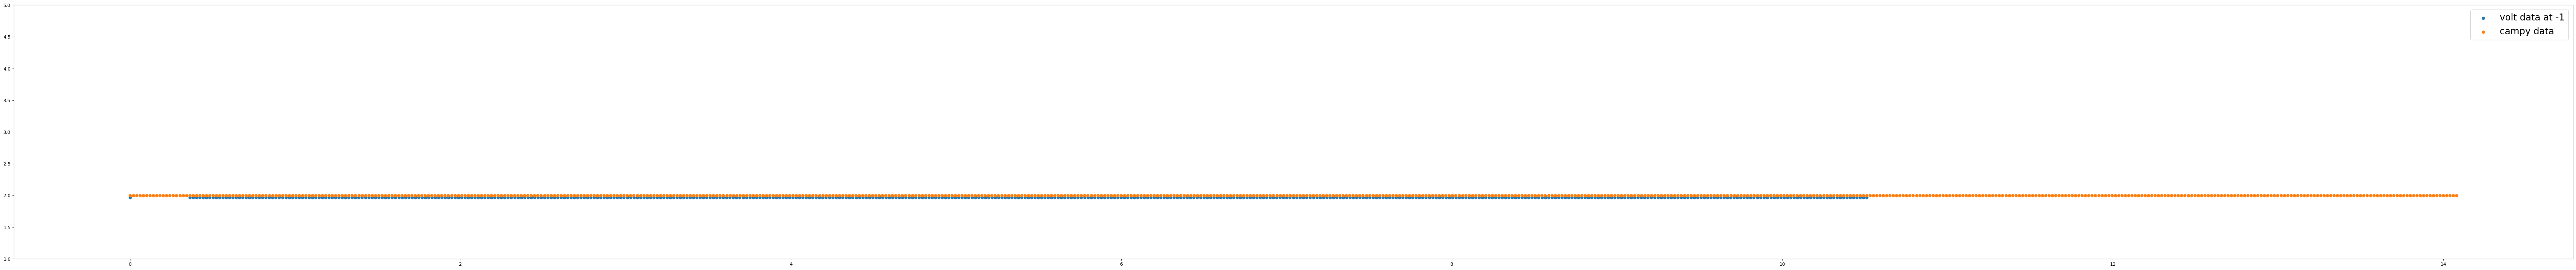

In [29]:
# volt_t_heights = [1.9,1.92,1.94,1.96,1.98]
volt_t_heights = [1.966667]
volt_ys = []
for volt_dat, y in zip (volt_t_list, volt_t_heights):
    volt_ys.append([y for t in volt_dat])
campy_ys = [2 for t in campy_times]
plt.figure(figsize=(100,10))
for i, volt_dat in enumerate(volt_t_list):
    plt.scatter(x=volt_dat, y=volt_ys[i], label=f"volt data at {i-1}")
plt.scatter(x=campy_times,y=campy_ys,label="campy data")

plt.ylim((1,5))

plt.legend(prop={'size':20})
plt.show()


In [42]:
dat, _, _ = HT.process_data_singletrial(trial, ploton=False, finger_raise_time=0.0)
touch_ts = []
for strok_touch in dat["strokes_touch"]:
    touch_ts.extend([p[2] for p in strok_touch])
print(touch_ts)

offset = touch_ts[1] - volt_t_list[0][1]
touch_ts = np.array(touch_ts) - offset

TODO: Get accurate frametime after pass in frame extraction to Buttons
Searching using this string:
/data3/hand_track/Pancho/221015_dircolor1/behavior/extracted_dlc_data/*camera*trial_14-*dat**
Found this many paths:
4
---
/data3/hand_track/Pancho/221015_dircolor1/behavior/extracted_dlc_data/camera_bfs1_-trial_14-dat.pkl
---
/data3/hand_track/Pancho/221015_dircolor1/behavior/extracted_dlc_data/camera_flea_-trial_14-dat.pkl
---
/data3/hand_track/Pancho/221015_dircolor1/behavior/extracted_dlc_data/camera_fly1_-trial_14-dat.pkl
---
/data3/hand_track/Pancho/221015_dircolor1/behavior/extracted_dlc_data/camera_fly2_-trial_14-dat.pkl
500.0
[3.834, 3.836, 3.838, 3.84, 3.842, 3.844, 3.846, 3.848, 3.85, 3.852, 3.854, 3.856, 3.858, 3.86, 3.862, 3.864, 3.866, 3.868, 3.87, 3.872, 3.874, 3.876, 3.878, 3.88, 3.882, 3.884, 3.886, 3.888, 3.89, 3.892, 3.894, 3.896, 3.898, 3.9, 3.902, 3.904, 3.906, 3.908, 3.91, 3.912, 3.914, 3.916, 3.918, 3.92, 3.922, 3.924, 3.926, 3.928, 3.93, 3.932, 3.934, 3.936, 3.938

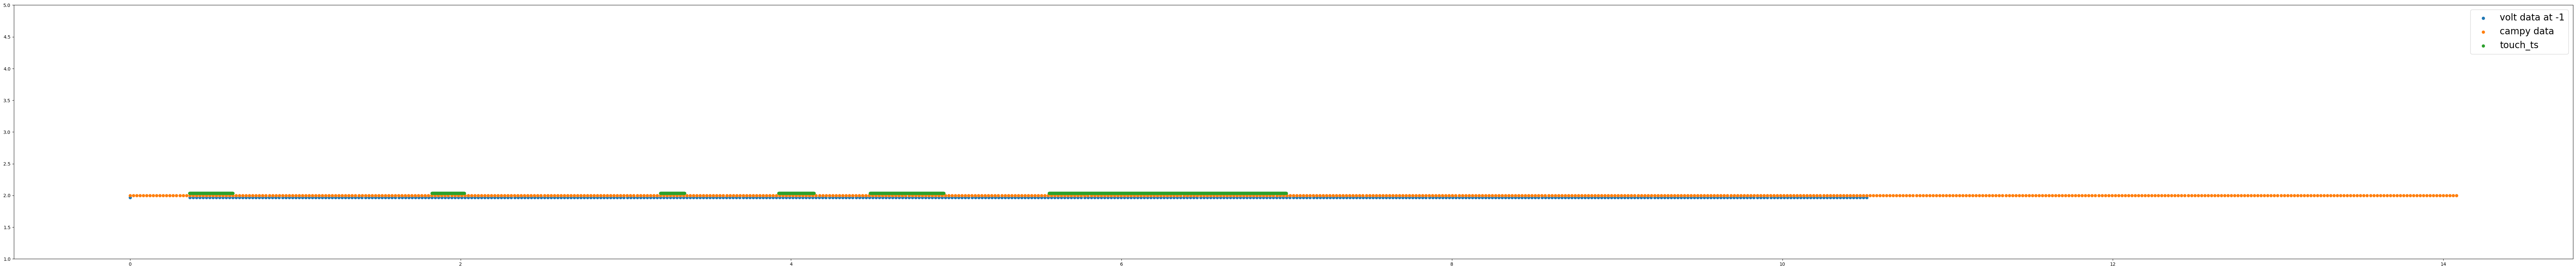

In [45]:
plt.figure(figsize=(100,10))
for i, volt_dat in enumerate(volt_t_list):
    plt.scatter(x=volt_dat, y=volt_ys[i], label=f"volt data at {i-1}")
plt.scatter(x=campy_times,y=campy_ys,label="campy data")
plt.scatter(x=touch_ts,y=[2.033 for p in touch_ts],label="touch_ts")

plt.ylim((1,5))

plt.legend(prop={'size':20})
plt.show()

In [17]:
dist_campy = pd.Series(campy_times).diff().mean()
dist_volt = pd.Series(volt_t_list[1])[3:].diff().mean()

print("campy dist:", dist_campy, "campy len", len(campy_ys))
print("volt_dist:", dist_volt, "volt len", len(volt_t_list[1]))

campy dist: 0.02005827246388277 campy len 444
volt_dist: 0.020058479532163744 volt len 517


0        NaN
1      0.020
2      0.352
3      0.020
4      0.020
       ...  
512    0.022
513    0.020
514    0.020
515    0.020
516    0.020
Length: 517, dtype: float64
0.352
2
515
444


ValueError: x and y must be the same size

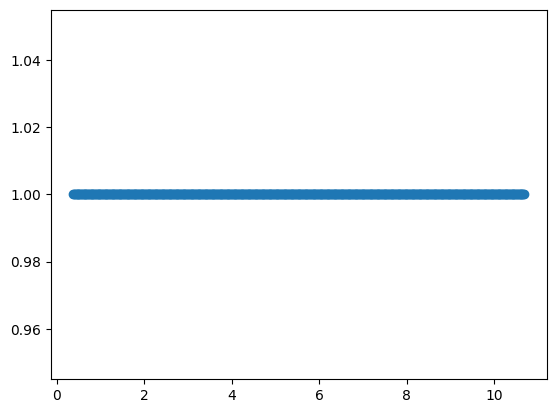

In [18]:
volt_times = pd.Series(volt_t_list[1])

volt_diffs = volt_times.diff()
print(volt_diffs)

volt_max = max([d for d in volt_diffs if str(d) != "nan"])
print(volt_max)
max_ind = 0
for i in range(len(volt_diffs)):
    if str(volt_diffs[i]) != "nan":
        if volt_diffs[i] == volt_max:
            max_ind = i
            break
print(max_ind)

volt_align = volt_times[max_ind:]
volt_ys = [1 for t in volt_align]


cam_align = campy_times[0:len(volt_align)]
cam_ys = [2 for t in volt_align]
print(len(volt_align))
print(len(cam_align))

plt.scatter(x=volt_align, y = volt_ys)
plt.scatter(x=cam_align, y = cam_ys)

In [18]:
dat, _ = HT.process_data_singletrial(4, ploton=False, finger_raise_time=0.0)

TODO: Get accurate frametime after pass in frame extraction to Buttons
Searching using this string:
/data3/hand_track/Pancho/221101_dirshapecolor3/behavior/extracted_dlc_data/*camera*trial_7-*dat**
Found this many paths:
4
---
/data3/hand_track/Pancho/221101_dirshapecolor3/behavior/extracted_dlc_data/camera_bfs1_-trial_7-dat.pkl
---
/data3/hand_track/Pancho/221101_dirshapecolor3/behavior/extracted_dlc_data/camera_flea_-trial_7-dat.pkl
---
/data3/hand_track/Pancho/221101_dirshapecolor3/behavior/extracted_dlc_data/camera_fly1_-trial_7-dat.pkl
---
/data3/hand_track/Pancho/221101_dirshapecolor3/behavior/extracted_dlc_data/camera_fly2_-trial_7-dat.pkl
x (476,)
y (476,)
z (476,)
t (476,)
t_trial (476,)
likelihood_min (476,)
500.0
